# Trying out own annotated data

Saving export-data-Pitchside-2023-03-20T14_59_20.785395Z_video_object_tracking_Pitchside_vot-4240763571773898752_data-00001-of-00001 (1).jsonl to export-data-Pitchside-2023-03-20T14_59_20.785395Z_video_object_tracking_Pitchside_vot-4240763571773898752_data-00001-of-00001 (1) (18).jsonl
Uploaded file: export-data-Pitchside-2023-03-20T14_59_20.785395Z_video_object_tracking_Pitchside_vot-4240763571773898752_data-00001-of-00001 (1).jsonl
Available time offsets: []
No time offsets found in the data


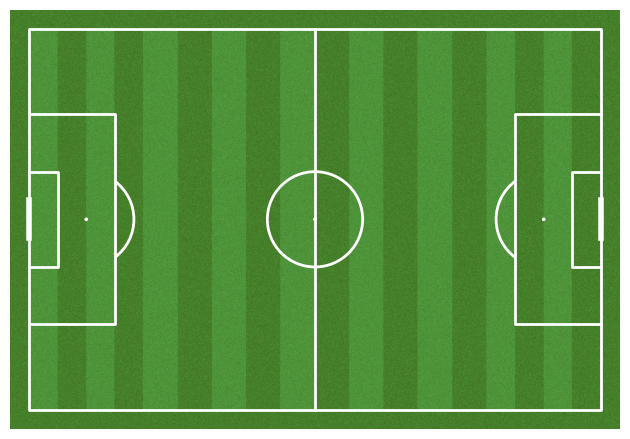

In [20]:
import json
import matplotlib.pyplot as plt
import os
import re
from google.colab import files
from io import StringIO
from mplsoccer import Pitch

uploaded = files.upload()

for file_name in uploaded.keys():
    file_path = file_name
    break

print(f"Uploaded file: {file_path}")

data = []
with open(file_path, "r") as file:
    for line in file:
        data.append(json.loads(line))

time_offsets = sorted(
    set(
        float(item.get("timeOffset", "0").rstrip("s"))
        for item in data
        if item.get("displayName") == "Player"
    )
)
print(f"Available time offsets: {time_offsets}")

if time_offsets:
    selected_time_offset = time_offsets[0]  # Change the index as needed
else:
    print("No time offsets found in the data")
    selected_time_offset = None

player_coordinates = []
for item in data:
    if (
        item.get("displayName") == "Player"
        and float(item.get("timeOffset", "0").rstrip("s")) == selected_time_offset
    ):
        x = (item["xMin"] + item["xMax"]) / 2
        y = (item["yMin"] + item["yMax"]) / 2
        player_coordinates.append((x, y))

pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw()

# Convert x and y coordinates to pitch dimensions (0-120 and 0-80)
player_coordinates_pitch = [(x * 120, y * 80) for x, y in player_coordinates]

for coord in player_coordinates_pitch:
    ax.scatter(*coord, marker="o", color="red")

plt.show()


Unfortunately the data annotated through Vertex AI - Google Cloud is not working. Thus I will use an existing dataset that containts event data gained through computer vision

# Football pitch

In [21]:
import os
import ipywidgets as widgets
import io

from bqplot import *
import numpy as np
import pandas as pd
import qgrid

In [22]:
PITCH_WIDTH = 105.0
PITCH_HEIGHT = 68.0
OFFSET = 3.0
OFFSET_WIDTH = OFFSET/PITCH_WIDTH
OFFSET_HEIGHT = OFFSET/PITCH_HEIGHT
X = [-OFFSET_WIDTH, 1+OFFSET_WIDTH]
Y_rev = [-OFFSET_HEIGHT, 1+OFFSET_HEIGHT]

# Only used to fix some issues in voila
WIDTH = 506.7
HEIGHT = 346.7
FACTOR = 1.8

class RadarViewWidget(widgets.VBox):
    def __init__(self, pitch_img='pitch.png', enable_logging=True):
        super().__init__()
        self.pitch_img = pitch_img
        self.enable_logging = enable_logging
        self.image = self.__init_image()
        self.home_scatter = self.__init_scatter()
        self.away_scatter = self.__init_scatter()
        self.ball_scatter = self.__init_scatter(size=64, selected_opacity=1.0)
        
        self.fig = Figure(marks=[self.image, self.home_scatter, self.away_scatter, self.ball_scatter], padding_x=0, padding_y=0)
        self.fig.layout = widgets.Layout(width=f'{WIDTH*FACTOR}px', height=f'{HEIGHT*FACTOR}px')
        self.output = widgets.Output()
        
        self.children = [self.fig, self.output]
        
    
    def __init_image(self):
        # read pitch image
        image_path = os.path.abspath(self.pitch_img)

        with open(image_path, 'rb') as f:
            raw_image = f.read()
        ipyimage = widgets.Image(value=raw_image, format='png')

        scales_image = {'x': LinearScale(), 'y': LinearScale(reverse=True)}
        axes_options = {'x': {'visible': True}, 'y': {'visible': True}}

        image = Image(image=ipyimage, scales=scales_image, axes_options=axes_options)
        # Full screen
        image.x = X
        image.y = Y_rev
        
        return image
        
    def __init_scatter(self, size=128, selected_opacity=0.6, unselected_opacity=1.0):
        scales={'x': LinearScale(min=X[0], max=X[1]), 'y': LinearScale(min=Y_rev[0], max=Y_rev[1], reverse=True)}
        axes_options = {'x': {'visible': False}, 'y': {'visible': False}}

        scatter = Scatter(
                            scales= scales, 
                            default_size=size,
                            interactions={'click': 'select'},
                            selected_style={'opacity': selected_opacity, 'stroke': 'Black'},
                            unselected_style={'opacity': unselected_opacity},
                            axes_options=axes_options)
        scatter.enable_move = True
        
        if self.enable_logging:
            scatter.on_drag_end(self.output_data)
        
        return scatter
    
    def disable_move(self):
        self.home_scatter.enable_move = False
        self.away_scatter.enable_move = False
        self.ball_scatter.enable_move = False

    def output_data(self, name, data):
        new_x = round(data['point']['x'], 2)
        new_y = round(data['point']['y'], 2)
        
        self.output.clear_output()
        with self.output:
            print(f'Changed player coordinates to ({new_x},{new_y})')
    
    def set_data(self, frameset):
        self.home_scatter.x = frameset['home_x']
        self.home_scatter.y = frameset['home_y']
        self.home_scatter.names=frameset['home_names'],
        self.home_scatter.colors=frameset['home_color']
        
        self.away_scatter.x = frameset['away_x']
        self.away_scatter.y = frameset['away_y']
        self.away_scatter.names=frameset['away_names'],
        self.away_scatter.colors=frameset['away_color']
        
        self.ball_scatter.x = frameset['ball_x']
        self.ball_scatter.y = frameset['ball_y']
        self.ball_scatter.colors = frameset['ball_color']
        

In [23]:
def get_playerid(name): return name[6:]
def get_frameset(frameid):
    return {
        'home_x': df_home.iloc[frameid, 2:-3:2].dropna().values,
        'home_y': df_home.iloc[frameid, 3:-3:2].dropna().values,
        'home_names': [get_playerid(name) for name in df_home.iloc[frameid, 2:-3:2].dropna().index.values],
        'home_color': ['blue'],
        'ball_x': df_home.iloc[frameid, [-2]].values,
        'ball_y': df_home.iloc[frameid, [-1]].values,
        'ball_color': ['black'],
        'away_x': df_away.iloc[frameid, 2:-3:2].dropna().values,
        'away_y': df_away.iloc[frameid, 3:-3:2].dropna().values,
        'away_names': [get_playerid(name) for name in df_away.iloc[frameid, 2:-3:2].dropna().index.values],
        'away_color': ['red'],
        
    }

# Testing to Move Players on a Football Pitch


In [24]:
from google.colab import output
output.enable_custom_widget_manager()


In [26]:
widget = RadarViewWidget(pitch_img='pitch.png')
display(widget)


df_home = pd.read_csv('Sample_Game_1_RawTrackingData_Home_Team.csv', index_col=0, skiprows=[0,1])
df_away = pd.read_csv('Sample_Game_1_RawTrackingData_Away_Team.csv', index_col=0, skiprows=[0,1])

frameid = 0
initial_frameset = get_frameset(frameid)

widget.set_data(initial_frameset)


RadarViewWidget(children=(Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(…

In [ ]:
# Speedup animation
STEP = 2

display(widget)

play = widgets.Play(
    value=0,
    step=STEP,
    max=len(df_home),
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(max=len(df_home))
widgets.jslink((play, 'value'), (slider, 'value'))

def change_data(change):
    widget.set_data(get_frameset(change['new']))
    
slider.observe(change_data, names='value')
slider.value
widgets.HBox([play, slider])

RadarViewWidget(children=(Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(…